# Initialization

In [244]:
%reload_ext autoreload
%autoreload 2

In [245]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [246]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 5
ROUNDS = 5
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [258]:
SHOTS = int(1e4)
P_AMBIG = 0

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG)
print(extreme_IQ_data.shape)

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

(10000, 25)


# Get counts from IQ data

In [259]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

{'00000 0000 0000 0000 0000 0000': 10000}


# Decode IQ data

In [237]:
import pymatching
import stim


circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=0.0001, #two-qubit-fidelity,
                                after_reset_flip_probability=0.0001, #reset error,
                                before_measure_flip_probability=0.0001, #measurement error,
                                before_round_data_depolarization=0.0001) #idle error)
# print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

In [238]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=P_DATA, p_mixed=P_MIXED,
                                           common_measure=-1, _bimodal=False, merge_strategy = "replace", _detailed=True)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

num_errors: 0 out of 1000 shots


In [239]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 152 out of 1000 shots


In [240]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS
# p_meas = 0e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data, 
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = P_DATA, p_mixed = P_MIXED, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 0 out of 1000 shots


# Plot the results

In [241]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [] 
Flat: [3, 21, 23, 28, 30, 32, 40, 45, 46, 60, 62, 79, 89, 91, 96, 110, 114, 120, 123, 127, 133, 142, 145, 148, 151, 156, 157, 171, 173, 184, 187, 189, 193, 194, 197, 198, 208, 231, 234, 244, 245, 254, 255, 268, 270, 286, 287, 289, 293, 294, 299, 314, 326, 331, 332, 339, 340, 346, 352, 354, 356, 357, 359, 360, 363, 370, 378, 389, 398, 399, 402, 403, 412, 415, 418, 419, 443, 446, 450, 483, 485, 499, 500, 505, 508, 514, 515, 540, 541, 543, 550, 565, 570, 577, 600, 603, 606, 608, 613, 615, 622, 625, 635, 636, 646, 647, 657, 662, 666, 669, 677, 678, 694, 700, 704, 708, 714, 730, 752, 761, 765, 767, 769, 770, 771, 782, 791, 802, 804, 807, 810, 813, 827, 841, 851, 854, 858, 863, 866, 876, 891, 892, 895, 908, 915, 933, 945, 948, 955, 966, 981, 988] 
Informed []


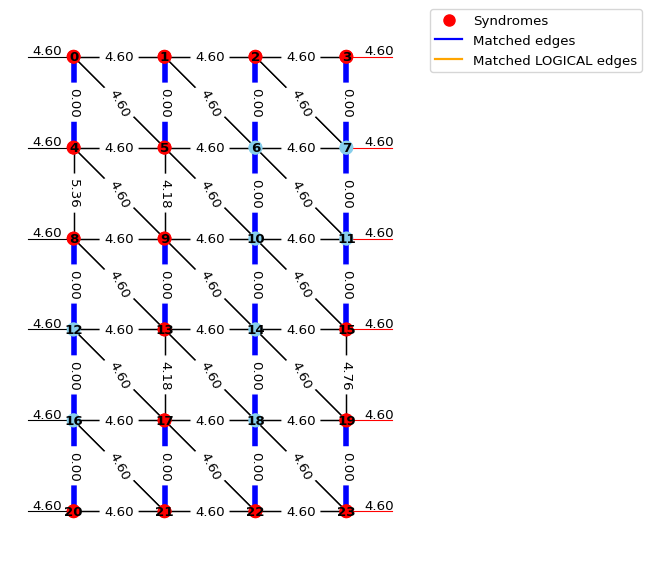

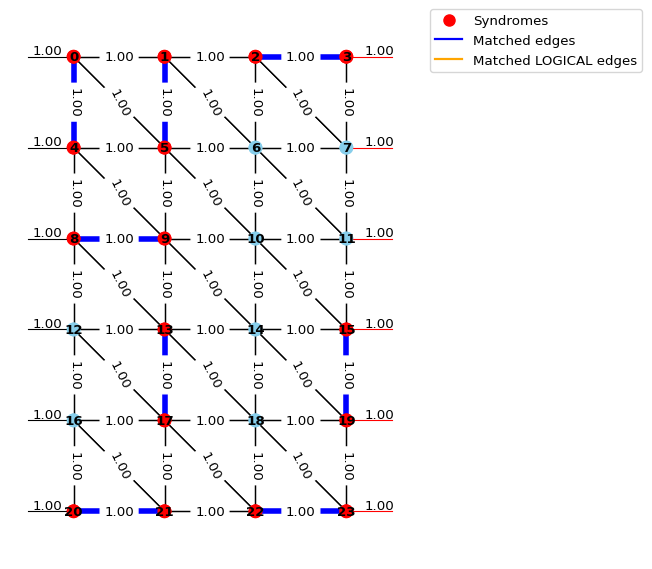

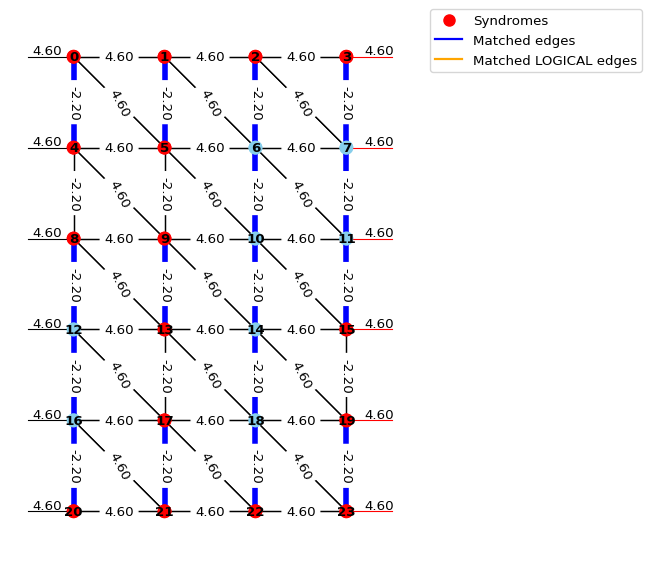

In [243]:
from soft_info import draw_matching_graph


index = 0

fig_size = (4, 13)
scale_factor = 0.8

to_be_result = result
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)
